In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import *
from pyspark.sql.types import DateType, IntegerType, StringType, FloatType
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
                      
spark = SparkSession.builder.appName("UnsupervisedLearning").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [3]:
df = spark.read.csv('joined_df.csv',inferSchema=True,header=True)

In [4]:
df.limit(4).toPandas()

,balcon_door_contact,bathroom_ambience_motion,bedroom_ambience_motion,bedroom_ambience_bed_motion,corridor_ambience_motion,entrance_door_contact,kitchen_ambience_motion,kitchen_fridge_contact,livingroom_ambience_motion,kitchen_coffeemaker_current,...,bathroom_washingmachine_current,kitchen_microwave_current,corridor_ilifeRobot_current,bathroom_ambience_light,bedroom_bed_pressure,livingroom_tv_light,bedroom_weightscale_pressure,bathroom_ambience_temperature,kitchen_stove_light,livingroom_couch_pressure
0,0.000347,0.001065,0.005035,0.000000,0.007824,0.000000,0.036297,0.004803,0.014954,0.0,...,0.0,0.0,0.0,0.0,613.129376,1022.974178,0.000000,21.535197,581.785079,257.161229
1,0.000833,0.164770,0.094214,0.000556,0.023773,0.001192,0.089179,0.002523,0.009780,0.0,...,0.0,0.0,0.0,0.0,592.827162,942.381324,1.993646,22.944518,306.540261,234.240524
2,0.009803,0.094502,0.006308,0.000000,0.001551,0.000000,0.009514,0.001296,0.003021,0.0,...,0.0,0.0,0.0,0.0,599.822315,757.095648,0.000000,22.043391,550.359792,232.857928
3,0.000000,0.208288,0.116303,0.000197,0.005267,0.001945,0.040639,0.006054,0.003183,0.0,...,0.0,0.0,0.0,0.0,591.081220,1022.657596,21.462700,21.130000,498.859598,229.149453


In [5]:
from pyspark.ml.feature import VectorAssembler
input_columns = df.columns # Collect the column names as a list
input_columns = input_columns[1:] # keep only relevant columns: from column 8 until the end
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_kmeans = vecAssembler.transform(df) #.select('CUST_ID', 'features')
df_kmeans.limit(4).toPandas()

,balcon_door_contact,bathroom_ambience_motion,bedroom_ambience_motion,bedroom_ambience_bed_motion,corridor_ambience_motion,entrance_door_contact,kitchen_ambience_motion,kitchen_fridge_contact,livingroom_ambience_motion,kitchen_coffeemaker_current,...,kitchen_microwave_current,corridor_ilifeRobot_current,bathroom_ambience_light,bedroom_bed_pressure,livingroom_tv_light,bedroom_weightscale_pressure,bathroom_ambience_temperature,kitchen_stove_light,livingroom_couch_pressure,features
0,0.000347,0.001065,0.005035,0.000000,0.007824,0.000000,0.036297,0.004803,0.014954,0.0,...,0.0,0.0,0.0,613.129376,1022.974178,0.000000,21.535197,581.785079,257.161229,"(0.001064827139203, 0.00503478049514462, 0.0, ..."
1,0.000833,0.164770,0.094214,0.000556,0.023773,0.001192,0.089179,0.002523,0.009780,0.0,...,0.0,0.0,0.0,592.827162,942.381324,1.993646,22.944518,306.540261,234.240524,"[0.16477042558362945, 0.09421405340339588, 0.0..."
2,0.009803,0.094502,0.006308,0.000000,0.001551,0.000000,0.009514,0.001296,0.003021,0.0,...,0.0,0.0,0.0,599.822315,757.095648,0.000000,22.043391,550.359792,232.857928,"(0.09450231481481482, 0.006307870370370371, 0...."
3,0.000000,0.208288,0.116303,0.000197,0.005267,0.001945,0.040639,0.006054,0.003183,0.0,...,0.0,0.0,0.0,591.081220,1022.657596,21.462700,21.130000,498.859598,229.149453,"[0.20828751663869438, 0.11630302679553214, 0.0..."


In [6]:
# Find the best amount of clusters
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# set a max for the number of clusters you want to try out
kmax = 15
# Create and array filled with zeros for the amount of k
# Similar to creating an empty list
kmcost = np.zeros(kmax)
for k in range(2,kmax):
    # Set up the k-means alogrithm
    kmeans = KMeans().setK(k).setFeaturesCol("features")
    # Fit it on your dataframe
    model = kmeans.fit(df_kmeans)
    # Fill in the zeros of your array with cost....
    # Computes the "cost" (sum of squared distances) between the input points and their corresponding cluster centers.
    # For Spark 2.0 to 3.0
#     kmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    kmcost[k] = evaluator.evaluate(predictions) #computing Silhouette score

Text(0, 0.5, 'cost')

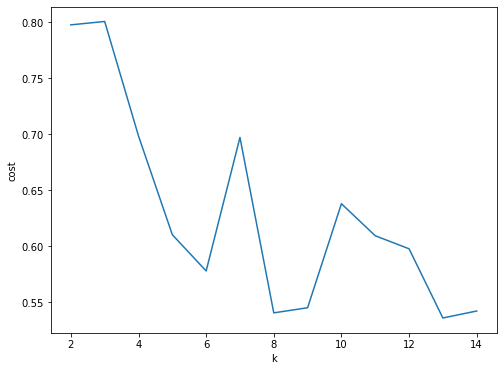

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up the plot dimensions
fig, ax = plt.subplots(1,1, figsize =(8,6))
# Then specify the range of values for the axis and call on your cost array
ax.plot(range(2,kmax),kmcost[2:kmax])
# Set up the axis labels
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [8]:
from pyspark.ml.clustering import BisectingKMeans

# Same calls here except with bkmeans
kmax = 15
bkmcost = np.zeros(kmax)
for k in range(2,kmax):
    bkmeans = BisectingKMeans().setK(k).setFeaturesCol("features")
    model = bkmeans.fit(df_kmeans)
    
    # For Spark > 2.0 AND Spark < 3.0
#     bkmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    bkmcost[k] = evaluator.evaluate(predictions) #computes Silhouette score

Text(0, 0.5, 'cost')

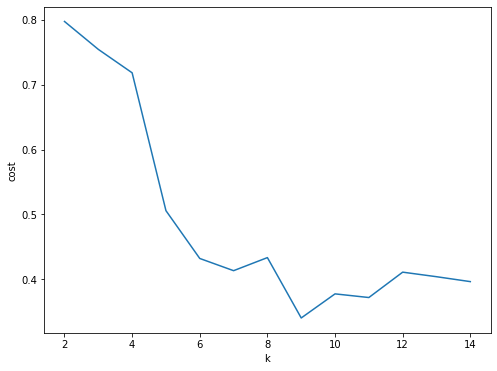

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

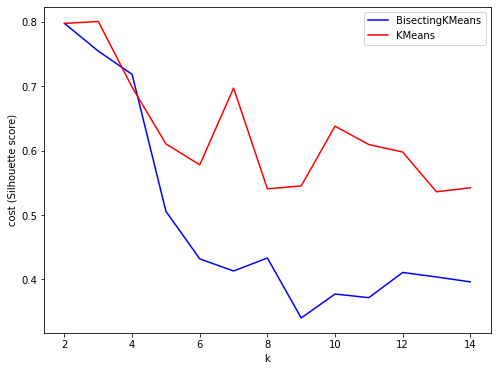

In [10]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax],color='blue',label="BisectingKMeans")
ax.plot(range(2,kmax),kmcost[2:kmax],color='red',label="KMeans")
ax.set_xlabel('k')
ax.set_ylabel('cost (Silhouette score)')
plt.legend()

In [11]:
def compare(bkmcost,kmcost):
    diff = []
    for k in range(2,kmax):
        temp = k,(kmcost[k]-bkmcost[k])
        diff.append(temp)
    return(diff)

diff_list = compare(bkmcost,kmcost)
diff_list

[(2, 0.0),
 (3, 0.046046387948551315),
 (4, -0.019909090732867174),
 (5, 0.10466352656447664),
 (6, 0.146019355283586),
 (7, 0.283952063331983),
 (8, 0.10735059155175802),
 (9, 0.2050057191601553),
 (10, 0.2606063045284355),
 (11, 0.2376772543087895),
 (12, 0.18693778436583963),
 (13, 0.13224218960459366),
 (14, 0.14603658544571974)]

In [15]:
k = 9
# kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
# model = kmeans.fit(df_kmeans)

bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = bkmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")

# Shows the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.3417920068927815
 
Cluster Centers: 
[0.00000000e+00 0.00000000e+00 6.14665929e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.34902932e+02
 4.97415020e+02 1.85846256e+02 9.07485706e+00 2.32393745e+01
 2.09175785e+01 4.33835902e+01]
[6.68356494e-02 4.68954412e-02 7.14803401e-03 2.63994173e-02
 6.14873271e-04 3.51851479e-02 2.37443282e-03 1.47551844e-02
 8.84100071e-04 2.27909706e-03 2.44988448e-02 1.44709423e-06
 2.92158568e-02 3.67476852e-04 2.36545139e-03 3.87685055e+01
 5.72673444e+02 6.16493954e+02 8.78369484e+00 2.14125477e+01
 4.09498885e+02 2.12650505e+02]
[1.44776378e-01 1.02082600e-01 3.03312500e-03 1.95341675e-02
 2.39996120e-03 3.03510677e-02 2.33451012e-03 1.04983131e-02
 5.65366966e-04 1.23009134e-03 2.70892481e-02 2.04876034e-05
 5.96793774e-03 1.21394130e-04 2.17842490e-03 1.24475417e+0

In [17]:
# Those are a little bit hard to read
# Let's convert to a dataframe so we can add the column names
import pandas as pd
import numpy as np
center_pdf = pd.DataFrame(list(map(np.ravel,centers)))
center_pdf.columns = df.columns[1:]
center_pdf

,bathroom_ambience_motion,bedroom_ambience_motion,bedroom_ambience_bed_motion,corridor_ambience_motion,entrance_door_contact,kitchen_ambience_motion,kitchen_fridge_contact,livingroom_ambience_motion,kitchen_coffeemaker_current,kitchen_sandwichmaker_current,...,bathroom_washingmachine_current,kitchen_microwave_current,corridor_ilifeRobot_current,bathroom_ambience_light,bedroom_bed_pressure,livingroom_tv_light,bedroom_weightscale_pressure,bathroom_ambience_temperature,kitchen_stove_light,livingroom_couch_pressure
0,0.000000,0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,134.902932,497.415020,185.846256,9.074857,23.239375,20.917579,43.383590
1,0.066836,0.046895,0.007148,0.026399,0.000615,0.035185,0.002374,0.014755,0.000884,0.002279,...,0.029216,0.000367,0.002365,38.768505,572.673444,616.493954,8.783695,21.412548,409.498885,212.650505
2,0.144776,0.102083,0.003033,0.019534,0.002400,0.030351,0.002335,0.010498,0.000565,0.001230,...,0.005968,0.000121,0.002178,12.447542,585.298324,942.561220,7.441247,21.888314,435.845312,212.064664
3,0.050394,0.046104,0.003666,0.023407,0.000482,0.019220,0.001562,0.005212,0.000466,0.001054,...,0.015965,0.000056,0.001670,84.478001,589.615260,1015.640767,9.604216,22.094332,587.419096,205.995597
4,0.000000,0.009762,0.008721,0.009175,0.000504,0.021843,0.060486,0.008843,0.000246,0.000018,...,0.019650,0.000401,0.000245,989.974308,553.762049,991.859175,2.301995,21.910971,6.837639,17.745458
5,0.000000,0.003465,0.004395,0.005892,0.000413,0.011553,0.000590,0.003928,0.000424,0.000015,...,0.000000,0.000093,0.000050,993.423864,555.753118,988.311872,38.682243,22.880377,0.000000,218.585915
6,0.000248,0.023582,0.005582,0.045619,0.000863,0.016214,0.001527,0.006176,0.000716,0.003475,...,0.027332,0.000214,0.004945,729.156640,568.721863,805.047379,34.492377,22.476067,454.294078,171.070589
7,0.000000,0.018830,0.004966,0.048029,0.000601,0.011755,0.037627,0.002870,0.000682,0.001740,...,0.024550,0.000051,0.009828,816.822077,572.710108,1008.233807,26.208452,22.604899,437.680633,177.387836
8,0.000000,0.007708,0.007892,0.016937,0.000760,0.020292,0.064705,0.011329,0.000470,0.000861,...,0.041399,0.000215,0.003526,968.038670,559.507182,990.692381,42.712678,22.310729,491.920354,216.564513


In [18]:
predictions.limit(5).toPandas()

,balcon_door_contact,bathroom_ambience_motion,bedroom_ambience_motion,bedroom_ambience_bed_motion,corridor_ambience_motion,entrance_door_contact,kitchen_ambience_motion,kitchen_fridge_contact,livingroom_ambience_motion,kitchen_coffeemaker_current,...,corridor_ilifeRobot_current,bathroom_ambience_light,bedroom_bed_pressure,livingroom_tv_light,bedroom_weightscale_pressure,bathroom_ambience_temperature,kitchen_stove_light,livingroom_couch_pressure,features,prediction
0,0.000347,0.001065,0.005035,0.000000,0.007824,0.000000,0.036297,0.004803,0.014954,0.0,...,0.0,0.0,613.129376,1022.974178,0.000000,21.535197,581.785079,257.161229,"(0.001064827139203, 0.00503478049514462, 0.0, ...",3
1,0.000833,0.164770,0.094214,0.000556,0.023773,0.001192,0.089179,0.002523,0.009780,0.0,...,0.0,0.0,592.827162,942.381324,1.993646,22.944518,306.540261,234.240524,"[0.16477042558362945, 0.09421405340339588, 0.0...",2
2,0.009803,0.094502,0.006308,0.000000,0.001551,0.000000,0.009514,0.001296,0.003021,0.0,...,0.0,0.0,599.822315,757.095648,0.000000,22.043391,550.359792,232.857928,"(0.09450231481481482, 0.006307870370370371, 0....",2
3,0.000000,0.208288,0.116303,0.000197,0.005267,0.001945,0.040639,0.006054,0.003183,0.0,...,0.0,0.0,591.081220,1022.657596,21.462700,21.130000,498.859598,229.149453,"[0.20828751663869438, 0.11630302679553214, 0.0...",2
4,0.115347,0.228257,0.185606,0.007352,0.030354,0.001609,0.007766,0.000487,0.010777,0.0,...,0.0,0.0,594.772998,985.251155,7.498457,22.041579,569.416299,217.300686,"[0.22825717871115375, 0.18560566915184173, 0.0...",3
